## Adaboost

Los métodos de ensamble de modelos o métodos combinados intentan ayudar a mejorar el rendimiento de los modelos de Machine Learning al mejorar su precisión. Este es un proceso mediante el cual se construyen estratégicamente varios modelos de Machine Learning para resolver un problema particular.

El algoritmo AdaBoost (Adaptive Boosting) propone entrenar iterativamente una serie de clasificadores base, de tal modo que cada nuevo clasificador preste mayor atención a los datos clasificados erróneamente por los clasificadores anteriores, y combinarlos de tal modo que se obtenga un clasificador con elevadas prestaciones. Para ello, durante una serie de iteraciones entrena un clasificador que implementa una función asignándole un peso de salida, y lo añade al conjunto de modo que la salida global del sistema se obtenga como combinación lineal ponderada de todos los clasificadores base.

AdaBoost es un conjunto creado a partir de árboles de decisión agregados secuencialmente al modelo y los modelos posteriores en la secuencia corrigen las predicciones hechas por modelos anteriores.

En el caso de nuestro trabajo, vamos a utilizar dos algoritmos débiles: “Decision Tree”, “Logistic Regression” y "Random Forest"

In [28]:
# Importamos las librerías necesarias

import numpy as np
import pandas as pd
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score, auc, confusion_matrix, f1_score, precision_score, recall_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Representaciones graficas locales

%pylab
%matplotlib inline

%config InlineBackend.figure_format = 'retina'

# Obviamos los errores de actualización 

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 50)

# Ponemos la semilla
np.random.seed(0)

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [29]:
# Importamos la función de limpieza y preprocesado de datos
import frauddef # con solo las variables de research

In [30]:
# Importamos el dataset 
df = pd.read_csv('Explor_uscecchini28.csv')

In [31]:
# Establecemos las variables X e Y
X_train_nm, X_test_nm, y_train_nm, y_test_nm, X_train_sm, X_test_sm, y_train_sm, y_test_sm = frauddef.limpieza(df)

In [32]:
# Escalamos las variables con MinMaxScaler
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_nm = scaler.fit_transform(X_train_nm)
X_test_nm  = scaler.transform(X_test_nm)

##### Logistic Regression with Adaboost

Logistic Regression es de los mejores algoritmo de clasificación lineal para problemas de dos clases.

Es fácil de implementar, fácil de entender y obtiene excelentes resultados en una amplia variedad de problemas.

In [33]:
# Selección de parámetros de dt con la función "GridSearchCV"
lr = LogisticRegression()
param_grid = dict(penalty = ["l1","l2"], C= np.logspace(-3,3,7))# l1 lasso l2 ridge

# establecemos la validación cruzado con 2 divisiones, los parámetros y el uso de núcleos de memoria.
grid_lr = GridSearchCV(lr, param_grid, cv = 2, scoring='roc_auc', return_train_score=True)
# Entrenamiento del Grid
grid_lr.fit(X_train_nm, y_train_nm)

# Mejor parámetro
print("Best Parameters for LR with PCA: ", grid_lr.best_params_)

Best Parameters for LR with PCA:  {'C': 0.001, 'penalty': 'l2'}


In [34]:
# Selección de los parámetros LR con la función "GridSearchCV"
lr = LogisticRegression(penalty= grid_lr.best_params_['penalty']
                         , C= grid_lr.best_params_['C'])
ada = AdaBoostClassifier(lr)
# de los parámetros AdaBoostClassifier
param = dict(n_estimators = [90,100,200,500,1000],
        learning_rate= [0.05, 0.1, 0.5, 1, 10],
                    algorithm=['SAMME', 'SAMME.R'])

# Grid model AdaBoostClassifier
ada_grid = GridSearchCV(ada, param, cv=5, n_jobs= -1)

ada_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=LogisticRegression(C=0.001)),
             n_jobs=-1,
             param_grid={'algorithm': ['SAMME', 'SAMME.R'],
                         'learning_rate': [0.05, 0.1, 0.5, 1, 10],
                         'n_estimators': [90, 100, 200, 500, 1000]})

In [35]:
# Mejor parámetro AdaBoostClassifier
print("Best Parameters for Adaboost Classifier: ", ada_grid.best_params_)

Best Parameters for Adaboost Classifier:  {'algorithm': 'SAMME', 'learning_rate': 0.5, 'n_estimators': 90}


In [36]:
# Construcción del modelo AdaBoostClassifier
ada = AdaBoostClassifier(lr, n_estimators= ada_grid.best_params_['n_estimators']
                         , learning_rate= ada_grid.best_params_['learning_rate']
                         , algorithm=ada_grid.best_params_['algorithm'])
ada.fit(X_train_nm, y_train_nm)

AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=LogisticRegression(C=0.001),
                   learning_rate=0.5, n_estimators=90)

Logistic Regression with Adaboost Training Score:  0.8761061946902655
Logistic Regression with Adaboost Testing Score:  0.8979591836734694
- Nombre del Modelo: AdaBoostClassifier 
 
 - Precisión: 0.8979591836734694 | 
 - Exactitud: 0.92 | 
 - Exhaustividad: 0.8846153846153846 | 
 - F1: 0.9019607843137256 | 
 - AUC: 0.8988294314381271 |
 
 - Matriz de confusion: 
 [[21  2]
 [ 3 23]] 



Text(0.5, 1.0, 'AUC = 0.90')

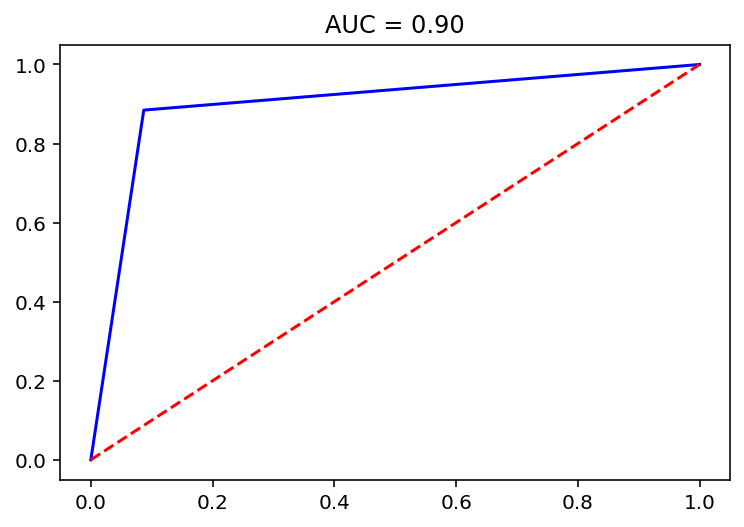

In [37]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.

print("Logistic Regression with Adaboost Training Score: ", ada.score(X_train_nm, y_train_nm))
print("Logistic Regression with Adaboost Testing Score: ", ada.score(X_test_nm, y_test_nm))

y_test_pred = ada.predict(X_test_nm)
y_train_pred = ada.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(ada.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))
    
plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [38]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_1 = ['Logistic Regression with Adaboost NearMiss', grid_lr.best_params_,
                  ada.score(X_train_nm, y_train_nm), ada.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

##### Decision Tree with Adaboost

Decision Tree es un método de predicción poderoso y extremadamente popular.

su populares reside en que el modelo final es muy fácil de entender tanto por profesionales como por expertos. Decision Tree puede explicar exactamente por qué se realizó una predicción específica, lo que la hace muy atractiva para el uso operativo.

Decision Tree también proporcionan la base para métodos de conjunto más avanzados como Adaboost.

In [39]:
# Selección de parámetros de dt con la función "GridSearchCV"
dt = DecisionTreeClassifier()
grid_param = dict(criterion=['gini','entropy'],max_depth= np.arange(1, 15))

# establecemos la validación cruzado con 2 divisiones, los parámetros y el uso de núcleos de memoria.
dt_grid = GridSearchCV(dt, grid_param, cv = 2, n_jobs = -1)
# Entrenamiento del Grid
dt_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])})

In [40]:
# Mejor parámetro Para DT
print("Best Parameters for Decision Tree Classifier with Adaboost: ", dt_grid.best_params_)

Best Parameters for Decision Tree Classifier with Adaboost:  {'criterion': 'entropy', 'max_depth': 4}


In [41]:
# Selección de los parámetros de DT con la función "GridSearchCV"

dt = DecisionTreeClassifier(max_depth= dt_grid.best_params_['max_depth']
                                ,criterion= dt_grid.best_params_['criterion'])
ada = AdaBoostClassifier(dt)

# los parámetros de AdaBoostClassifier
param = dict()

ada_grid = GridSearchCV(ada, param, cv=5, n_jobs= -1)
# Entrenamiento
ada_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                                                max_depth=4)),
             n_jobs=-1, param_grid={})

In [42]:
# Mejores parámetros AdaBoostClassifier
print("Best Parameters for Adaboost Classifier: ", ada_grid.best_params_)

Best Parameters for Adaboost Classifier:  {}


In [43]:
# Construcción del modelo AdaBoostClassifier
ada = AdaBoostClassifier(dt)

# entrenamiento del modelo AdaBoostClassifier
ada.fit(X_train_nm, y_train_nm)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(criterion='entropy',
                                                         max_depth=4))

Decision Tree Classifier with Adaboost Training Score:  1.0
Decision Tree Classifier with Adaboost Testing Score:  1.0
- Nombre del Modelo: AdaBoostClassifier 
 
 - Precisión: 1.0 | 
 - Exactitud: 1.0 | 
 - Exhaustividad: 1.0 | 
 - F1: 1.0 | 
 - AUC: 1.0 |
 
 - Matriz de confusion: 
 [[23  0]
 [ 0 26]] 



Text(0.5, 1.0, 'AUC = 1.00')

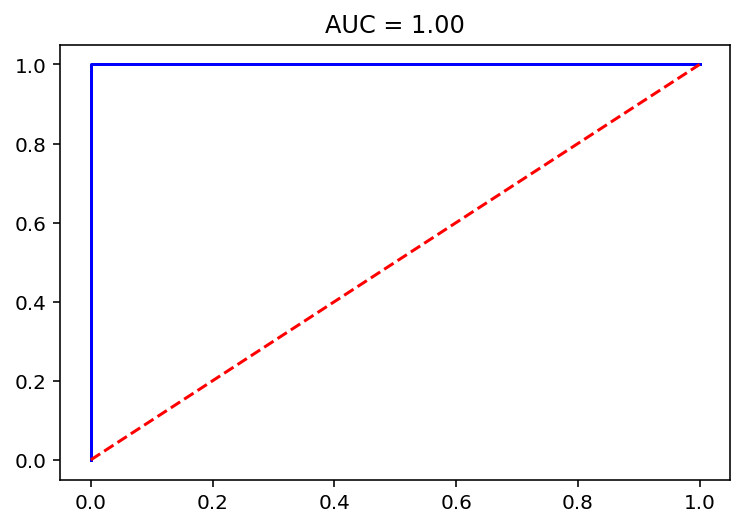

In [44]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.

print("Decision Tree Classifier with Adaboost Training Score: ", ada.score(X_train_nm, y_train_nm))
print("Decision Tree Classifier with Adaboost Testing Score: ", ada.score(X_test_nm, y_test_nm))

y_test_pred = ada.predict(X_test_nm)
y_train_pred = ada.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(ada.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))
    
plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [45]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_2 = ['Decision Tree Classifier with Adaboost NearMiss', ada_grid.best_params_,
                  ada.score(X_train_nm, y_train_nm), ada.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

##### Random Forest Classifier with Adaboost


In [46]:
# Selección de parámetros de dt con la función "GridSearchCV"
rf = RandomForestClassifier()
param_grid = dict(max_depth=[1,3,5,7,9,15], 
                  n_estimators= [100,250,500],criterion=['gini', 'entropy'])

# establecemos la validación cruzado con 2 divisiones, los parámetros y el uso de núcleos de memoria.
grid_rf = GridSearchCV(rf, param_grid, cv = 2, scoring='roc_auc', return_train_score=True)
# Entrenamiento del Grid
grid_rf.fit(X_train_nm, y_train_nm)

# Mejor parámetro
print("Best Parameters for RF with Adaboost: ", grid_rf.best_params_)

Best Parameters for RF with Adaboost:  {'criterion': 'entropy', 'max_depth': 5, 'n_estimators': 100}


In [47]:
# Selección de los parámetros de LR con la función "GridSearchCV"
rf = RandomForestClassifier(n_estimators= grid_rf.best_params_['n_estimators']
                                , max_depth= grid_rf.best_params_['max_depth']
                                ,criterion = grid_rf.best_params_['criterion'])
ada = AdaBoostClassifier(rf)
# de los parámetros AdaBoostClassifier
param = dict()

ada_grid = GridSearchCV(ada, param, cv=5, n_jobs= -1)
# entrenamiento del Grid model AdaBoostClassifier
ada_grid.fit(X_train_nm, y_train_nm)

GridSearchCV(cv=5,
             estimator=AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                                                max_depth=5)),
             n_jobs=-1, param_grid={})

In [48]:
# Mejor parámetro AdaBoostClassifier
print("Best Parameters for Adaboost Classifier: ", ada_grid.best_params_)

Best Parameters for Adaboost Classifier:  {}


In [49]:
# Construcción del modelo AdaBoostClassifier
ada = AdaBoostClassifier(rf)

# entrenamiento del modelo AdaBoostClassifier
ada.fit(X_train_nm, y_train_nm)

AdaBoostClassifier(base_estimator=RandomForestClassifier(criterion='entropy',
                                                         max_depth=5))

Random Forest Classifier with Adaboost Training Score:  1.0
Random Forest Classifier with Adaboost Testing Score:  1.0
- Nombre del Modelo: AdaBoostClassifier 
 
 - Precisión: 1.0 | 
 - Exactitud: 1.0 | 
 - Exhaustividad: 1.0 | 
 - F1: 1.0 | 
 - AUC: 1.0 |
 
 - Matriz de confusion: 
 [[23  0]
 [ 0 26]] 



Text(0.5, 1.0, 'AUC = 1.00')

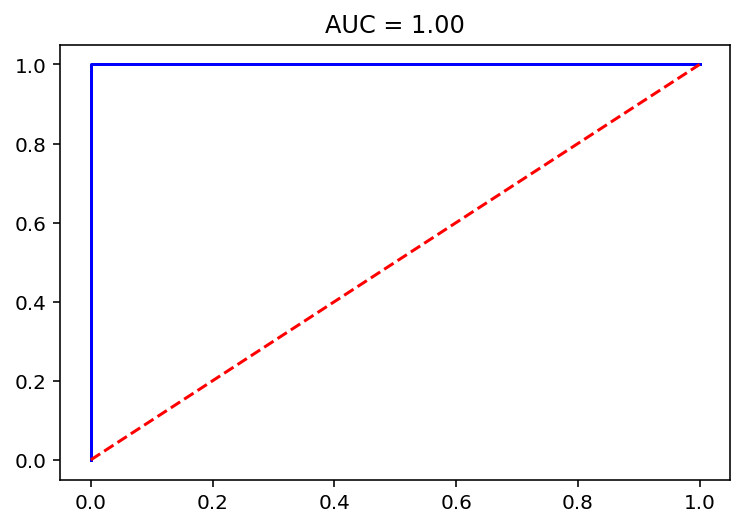

In [50]:
# Medición del rendimiento de los modelos; exactitud, exhaustividad, F1, Auc y matriz de confusión.

print("Random Forest Classifier with Adaboost Training Score: ", ada.score(X_train_nm, y_train_nm))
print("Random Forest Classifier with Adaboost Testing Score: ", ada.score(X_test_nm, y_test_nm))

y_test_pred = ada.predict(X_test_nm)
y_train_pred = ada.predict(X_train_nm)
cm = confusion_matrix(y_test_nm, y_test_pred)
false_positive_rate, recall, thresholds = roc_curve(y_test_nm, y_test_pred) # el area bajo la curva
roc_auc = auc(false_positive_rate, recall)
    
print("- Nombre del Modelo: {} \n" .format(ada.__class__.__name__) , "\n - Precisión: {} |" 
        .format(accuracy_score(y_test_nm, y_test_pred)), 
        "\n - Exactitud: {} |" .format(precision_score(y_test_nm, y_test_pred)), 
        "\n - Exhaustividad: {} |" .format(recall_score(y_test_nm, y_test_pred)), 
        "\n - F1: {} |" .format(f1_score(y_test_nm, y_test_pred)), 
        "\n - AUC: {} |\n" .format(auc(false_positive_rate, recall)),
        "\n - Matriz de confusion: \n {} \n" .format(cm))
    
plot(false_positive_rate, recall, 'b') # imprimir el ratio
plot([0, 1], [0, 1], 'r--') # difinir el ratio entre 0 y 1
title('AUC = %0.2f' % roc_auc)

In [51]:
# Guardamos la Medición del rendimiento de los modelos en una tabla.
report_table_3 = ['Random Forest Classifier with Adaboost NearMiss', grid_rf.best_params_,
                  ada.score(X_train_nm, y_train_nm), ada.score(X_test_nm, y_test_nm), recall_score(y_test_nm, y_test_pred),
                 f1_score(y_test_nm, y_test_pred), auc(false_positive_rate, recall)]

In [52]:
# Mostrar la Medición del rendimiento de los modelos en una tabla.
report_table = pd.DataFrame(list(zip(report_table_1,
             report_table_2,
             report_table_3))).transpose()

In [53]:
report_table.columns = ['Model Name', 'Model Parameter', 'Training Score', 'Testing Score', "Exhaustividad", "F1", "AUC"]
report_table.index = report_table['Model Name']
report_table.head(15)

,Model Name,Model Parameter,Training Score,Testing Score,Exhaustividad,F1,AUC
Model Name,,,,,,,
Logistic Regression with Adaboost NearMiss,Logistic Regression with Adaboost NearMiss,"{'C': 0.001, 'penalty': 'l2'}",0.876106,0.897959,0.884615,0.901961,0.898829
Decision Tree Classifier with Adaboost NearMiss,Decision Tree Classifier with Adaboost NearMiss,{},1,1,1,1,1
Random Forest Classifier with Adaboost NearMiss,Random Forest Classifier with Adaboost NearMiss,"{'criterion': 'entropy', 'max_depth': 5, 'n_es...",1,1,1,1,1


In [54]:
# guardamos los resultados
report_table.to_csv('Adaboost_With_NearMiss.csv')

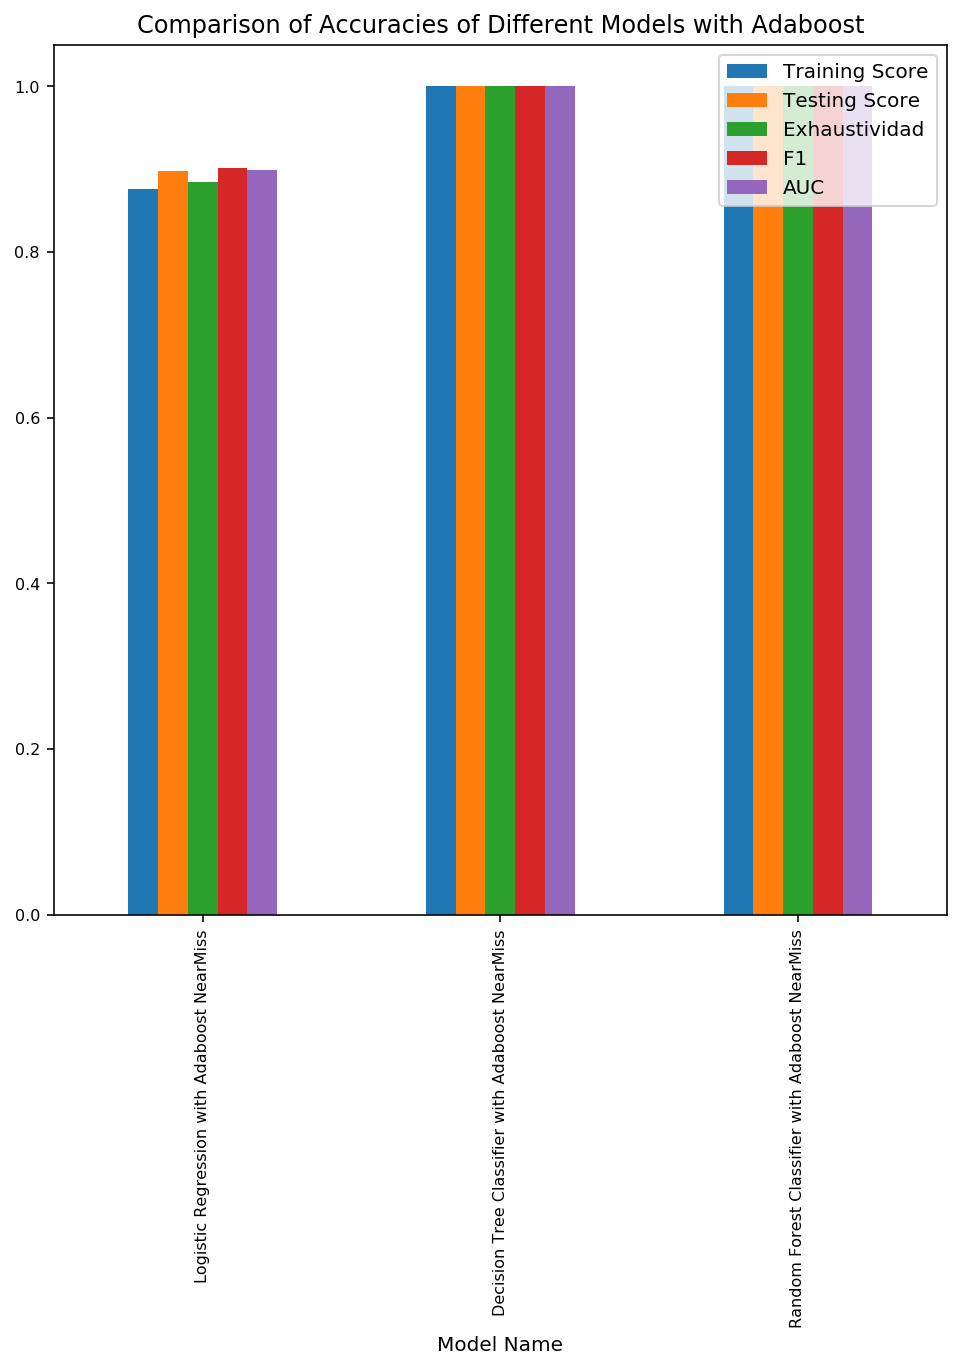

In [55]:
ax = report_table[['Model Name', 'Model Parameter', 'Training Score', 'Testing Score', "Exhaustividad", "F1", "AUC"]].plot(kind='bar',
            title = "Comparison of Accuracies of Different Models with Adaboost", figsize=(8, 8), fontsize = 8)
plt.show()